In [1]:
import pandas as pd
import evaluate
import sklearn

metrics_df = pd.read_csv(f'metrics.csv')

In [2]:
!pip install spacy
!python -m spacy download en_core_web_sm # language model
# for counting entities

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 12.4 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
best_model = metrics_df.sort_values(by=['accuracy'],  ascending=False).iloc[0]
print(best_model)

Unnamed: 0                           3
model                     DebertaLarge
preprocessor    sentence_embedding_cut
chunk_size                          64
accuracy                      0.550336
Name: 9, dtype: object


In [4]:
best_model['chunk_size']

'64'

In [94]:
experiment_df = pd.read_pickle('raw.pkl')

# only take experiment data from best model
experiment_df = experiment_df[
    (experiment_df['model'] == best_model['model']) &
    (experiment_df['preprocessor'] == best_model['preprocessor']) &
    (experiment_df['chunk_size'].astype(str) == best_model['chunk_size'])
]
print(experiment_df)

             model            preprocessor chunk_size  question_id  \
6258  DebertaLarge  sentence_embedding_cut         64            0   
6259  DebertaLarge  sentence_embedding_cut         64            1   
6260  DebertaLarge  sentence_embedding_cut         64            2   
6261  DebertaLarge  sentence_embedding_cut         64            3   
6262  DebertaLarge  sentence_embedding_cut         64            4   
...            ...                     ...        ...          ...   
8339  DebertaLarge  sentence_embedding_cut         64         2081   
8340  DebertaLarge  sentence_embedding_cut         64         2082   
8341  DebertaLarge  sentence_embedding_cut         64         2083   
8342  DebertaLarge  sentence_embedding_cut         64         2084   
8343  DebertaLarge  sentence_embedding_cut         64         2085   

                                                logits  prediction  label  \
6258  [-16.930977, -15.536155, -16.912373, -15.539847]           1      1   
6259 

In [6]:
# experiment dataframe
type(experiment_df.iloc[0]['chunk_ids'])

list

In [ ]:
# somehow selected_chunk_id is type string. don't do it if's a list already
#experiment_df1['selected_chunk_ids'] = experiment_df1['selected_chunk_ids'].apply(lambda x:[int(i) for i in x[1:-1].split(',')])

In [7]:
'''for index, row in experiment_df1.iterrows():
    selected_chunk_ids = row['selected_chunk_ids']
    print(selected_chunk_ids)'''

"for index, row in experiment_df1.iterrows():\n    selected_chunk_ids = row['selected_chunk_ids']\n    print(selected_chunk_ids)"

In [8]:
# question data
import json
import pandas as pd
questionlist = []
# Open the JSON file
with open('datasets/quality/raw/QuALITY.v1.0.1.htmlstripped.dev', 'r') as file:
    # Load the JSON data
    for line in file:
      line = line.strip()

      json_obj = json.loads(line)

      article = json_obj['article']
      article = article.replace("\n", "") # REPLACE LINEBREKAS
      
      for jquestion in json_obj['questions']:
        # getting the relevant properties
        row = {'article': article, 'question': jquestion['question'], 'options': jquestion['options'], 'gold_label': jquestion['gold_label']}
        questionlist.append(row)

# turn it into hugging face dataset
question_df = pd.DataFrame(questionlist)

In [ ]:
# question dataframe
question_df

In [9]:
merged_df = pd.merge(question_df, experiment_df, left_index=True,  right_on='question_id')

# Keep only specific columns
desired_columns = ['question_id', 'article', 'question', 'options', 'prediction', 'label', 'chunk_ids', 'logits']

merged_df  = merged_df[desired_columns]
merged_df.iloc[:5]

,question_id,article,question,options,prediction,label,chunk_ids,logits
6258,0,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,How much time has passed between Blake's night...,"[7 years, 10 hours, 12 years, 1 hour]",1,1,"[9, 15, 27, 32, 45, 75, 79]","[-16.930977, -15.536155, -16.912373, -15.539847]"
6259,1,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why does Deirdre get so upset when Blake Past ...,[Because Blake is trying to guilt Deirdre into...,2,1,"[14, 47, 49, 50, 55, 90]","[-3.7608008, -13.522014, 1.0634339, -13.528275]"
6260,2,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why does shame flame in Blake's cheeks when De...,[He is embarrassed at the thought that Deirdre...,3,2,"[9, 15, 18, 47, 50]","[-14.266091, -7.4051523, -7.856465, -3.9469354]"
6261,3,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why did Blake create the three female super-im...,[He feels guilty about having slept with Eldor...,3,3,"[58, 59, 60, 63, 75, 84]","[-15.647312, -16.070698, -17.48309, -12.98239]"
6262,4,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Sabrina York is,"[a criminal that Blake is hunting, a psycheye ...",0,0,"[25, 37, 38, 39, 75, 79, 81, 89]","[-5.404604, -18.456474, -18.671852, -11.828601]"


# 1. Finding out which type of questions are harder to predict (How/What/Who questions?)

In [10]:
def filterByQuestionType(df, question_type):
    return df[df['question'].str.lower().str.split().str[0] == question_type]

In [11]:
question_types = merged_df['question'].str.lower().str.split().str[0].unique()
#question_types = ['why']

question_tuples = []
print(f'total: { question_df.shape[0]}')
for question_type in question_types:
    filtered_df = filterByQuestionType(merged_df, question_type)
    total_cnt = filtered_df.shape[0]
    
    correct_cnt = len(filtered_df[filtered_df['label'] == filtered_df['prediction']])
    
    row = (question_type, total_cnt, correct_cnt)
    question_tuples.append(row)
    #print(row)
    

question_tuples = sorted(question_tuples, key=lambda x: x[1], reverse=True) # sort by total count

# only keep question types with tuples count larger than 10
thres = 5
question_tuples = list(filter(lambda x: x[1] > thres, question_tuples))
for (question_type, total_cnt, correct_cnt) in question_tuples:
    print(f'{question_type}: total={total_cnt}, correct={correct_cnt/total_cnt:.3f}')

total: 2086
what: total=809, correct=0.533
why: total=516, correct=0.578
how: total=332, correct=0.557
which: total=93, correct=0.527
who: total=58, correct=0.431
the: total=35, correct=0.629
of: total=34, correct=0.412
where: total=33, correct=0.515
according: total=22, correct=0.864
when: total=17, correct=0.353
in: total=13, correct=0.538
does: total=12, correct=0.750
if: total=9, correct=0.333
is: total=8, correct=0.375
did: total=6, correct=0.500


Conclusion: Look at which type of questions have lower percentage of correct answers.

# 2. Count number of number of entities as a source of information (Does more entity help to answer the question?) (TODO)

In [24]:
from baseline_retrieval import split_text_into_chunks 

In [95]:
# split text in chunks, add to dataframe
import numpy as np
max_token_size = -1
try:
    max_token_size = int(best_model['chunk_size'])
except ValueError:
    # then it's a string and we keep it this way
    max_token_size = best_model['chunk_size']
print(type(max_token_size))
merged_df['chunks'] = merged_df['article'].apply(split_text_into_chunks, max_token_size=max_token_size)

<class 'int'>


In [96]:
# save for all chunk_id in chunk_ids the exact chunk as text, in an array
for index, row in merged_df.iterrows():
    #print(type(row['chunks']))
    # merge text together 
    input_text =  "".join([row['chunks'][i] for i in row['chunk_ids']])
    #print(input_text)
    merged_df.loc[index, 'input'] = input_text
    #

In [99]:
merged_df.to_csv("human_analysis.csv", index=False)

In [28]:
import spacy
spacy.prefer_gpu()
nlp = spacy.load("en_core_web_sm")
doc = nlp("Apple is looking at buying U.K. startup for $1 billion")
print(len(doc.ents))
print(doc.ents)

3
(Apple, U.K., $1 billion)


In [29]:
# this takes a while since we need to perform NER for each row (approx. 5min)
for index, row in merged_df.iterrows():
    #print(type(row['chunks']))
    # merge text together 
    doc = nlp(row['input'])
    nb_entities = len(doc.ents)
    #print(input_text)
    merged_df.loc[index, 'nb_entities'] = nb_entities

In [ ]:
merged_df

In [ ]:
correct_preds = merged_df[merged_df['prediction'] == merged_df['label']]
col = correct_preds['nb_entities']
mean = col.mean()
var = col.var()
med = col.median()

print(f'Correctly classified samples: mean={mean:.4f}, var={var:.4f}, , median={med} ')

In [ ]:
correct_preds = merged_df[merged_df['prediction'] != merged_df['label']]
col = correct_preds['nb_entities']
mean = col.mean()
var = col.var()
med = col.median()

print(f'Falsely classified samples: mean={mean:.4f}, var={var:.4f}, , median={med} ')

# 3. Analyze the similarity of the selected chunks and see if there is a difference for falsely predicted and correctly predicted questions  (Does the model get feeded with redundant information?)

# 6. Analyze if similarity score is a good measurement (If the model gets feeded with chunks with high similarity score, is it more accurate at predicting?)

In [17]:
from sentence_transformers import SentenceTransformer, util

In [18]:
sentembb_model = SentenceTransformer('all-mpnet-base-v2',  device='cuda')

In [34]:
merged_df6 = merged_df.copy()
merged_df6.dtypes

question_id      int64
article         object
question        object
options         object
prediction       int64
label            int64
chunk_ids       object
logits          object
chunks          object
input           object
nb_entities    float64
dtype: object

In [35]:
merged_df6["similarity_scores"] = [[]] * merged_df6.shape[0] # create empty col
merged_df6["selected_chunks"] = [[]] * merged_df6.shape[0] # create empty col

In [38]:
for index, row in merged_df6.iterrows():
    merged_df6.at[index, 'selected_chunks'] = [row['chunks'][i] for i in row['chunk_ids']]

In [40]:
# takes like 5min to run, as we use the sentence transformer
for index, row in merged_df6.iterrows():
    #print(type(row['chunks']))
    query = row['question']
    corpus = row['selected_chunks']
    query_embedding = sentembb_model.encode(query)
    corpus_embeddings = sentembb_model.encode(corpus)
    similarity_scores = util.cos_sim(query_embedding, corpus_embeddings)[0]
    similarity_scores = list(similarity_scores.numpy())

    merged_df6.at[index, 'similarity_scores'] = similarity_scores

In [41]:
merged_df6

,question_id,article,question,options,prediction,label,chunk_ids,logits,chunks,input,nb_entities,similarity_scores,selected_chunks
6258,0,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,How much time has passed between Blake's night...,"[7 years, 10 hours, 12 years, 1 hour]",1,1,"[9, 15, 27, 32, 45, 75, 79]","[-16.930977, -15.536155, -16.912373, -15.539847]",[THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Trans...,Her hair made him think of the copper-colored ...,19.0,"[0.47554004, 0.4049722, 0.47980657, 0.4519455,...",[Her hair made him think of the copper-colored...
6259,1,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why does Deirdre get so upset when Blake Past ...,[Because Blake is trying to guilt Deirdre into...,2,1,"[14, 47, 49, 50, 55, 90]","[-3.7608008, -13.522014, 1.0634339, -13.528275]",[THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Trans...,When I grow up I shall be a most well-educated...,15.0,"[0.45747864, 0.5369153, 0.62816, 0.5888226, 0....",[When I grow up I shall be a most well-educate...
6260,2,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why does shame flame in Blake's cheeks when De...,[He is embarrassed at the thought that Deirdre...,3,2,"[9, 15, 18, 47, 50]","[-14.266091, -7.4051523, -7.856465, -3.9469354]",[THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Trans...,Her hair made him think of the copper-colored ...,13.0,"[0.42422178, 0.6323849, 0.4809482, 0.46296155,...",[Her hair made him think of the copper-colored...
6261,3,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Why did Blake create the three female super-im...,[He feels guilty about having slept with Eldor...,3,3,"[58, 59, 60, 63, 75, 84]","[-15.647312, -16.070698, -17.48309, -12.98239]",[THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Trans...,His next reaction was shock. His third was fea...,24.0,"[0.44008404, 0.5379476, 0.39775902, 0.5061847,...",[His next reaction was shock. His third was fe...
6262,4,THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Transc...,Sabrina York is,"[a criminal that Blake is hunting, a psycheye ...",0,0,"[25, 37, 38, 39, 75, 79, 81, 89]","[-5.404604, -18.456474, -18.671852, -11.828601]",[THE GIRL IN HIS MINDBy ROBERT F. YOUNG [Trans...,"After resting for a few minutes, he descended ...",17.0,"[0.26478145, 0.29234934, 0.32791167, 0.3295804...","[After resting for a few minutes, he descended..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8339,2081,"The end of the webIn the past year, as we have...",The author of this piece,[has radical ideas concerning how the internet...,3,3,"[0, 2, 6, 17, 28, 29, 45, 52]","[-10.950401, -0.34622887, -12.300265, 9.499415]","[The end of the webIn the past year, as we hav...","The end of the webIn the past year, as we have...",23.0,"[0.14489397, 0.102745034, 0.13917679, 0.041752...","[The end of the webIn the past year, as we hav..."
8340,2082,"The end of the webIn the past year, as we have...",The author is afraid,[that the dark web is going to cause long-last...,3,3,"[0, 1, 5, 10, 12, 13, 39, 52]","[1.0838537, -16.748371, -15.254489, 15.622661]","[The end of the webIn the past year, as we hav...","The end of the webIn the past year, as we have...",5.0,"[0.1390476, 0.08614773, 0.1126381, 0.20156893,...","[The end of the webIn the past year, as we hav..."
8341,2083,"The end of the webIn the past year, as we have...",What is ironic about the internet?,[It was never meant to be such a huge part of ...,0,1,"[0, 7, 14, 39, 41, 48, 50, 51]","[-6.420885, -16.962921, -9.344424, -13.803503]","[The end of the webIn the past year, as we hav...","The end of the webIn the past year, as we have...",12.0,"[0.52718043, 0.4353493, 0.37586582, 0.4800317,...","[The end of the webIn the past year, as we hav..."
8342,2084,"The end of the webIn the past year, as we have...",One way the internet is damaging society is,[by allowing social media to overtake the live...,1,1,"[1, 7, 13, 28, 35, 39, 46, 48]","[-14.7744055, 16.222631, -18.145699, -9.354968]","[The end of the webIn the past year, as we hav...",With domestic

In [42]:
merged_df6.iloc[3]['similarity_scores']

[0.44008404, 0.5379476, 0.39775902, 0.5061847, 0.46048942, 0.70497674]

In [258]:
#merged_df = merged_df.drop('similarity_scores', axis=1)

In [73]:
merged_df6['max_sim'] = merged_df6['similarity_scores'].apply(lambda x: np.max(x))
merged_df6['avg_sim'] = merged_df6['similarity_scores'].apply(lambda x: np.mean(x))

correct_df = merged_df6[merged_df6['prediction'] == merged_df6['label']].copy()

false_df = merged_df6[merged_df6['prediction'] != merged_df6['label']].copy()
correct_df.shape[0]

1148

In [44]:
merged_df6[(merged_df6['avg_sim'] >= 0.1) & (merged_df6['avg_sim'] < 0.2)]['question'][:15].values

array(['Who or what is Leo?', 'What was the dog?',
       'Where is International Police headquarters located?',
       'Who is the oldest character?', 'Why is a day 720 hours long?',
       'What is the author’s thesis?',
       'What is revealed about the credentials of the author through the piece?',
       'Do you think it would be fun to live in the universe in which this story takes place?',
       'Who would most likely enjoy this story, of the following options?',
       'Of the following options, which is not an issue discussed within this fantasy world?',
       'Of the following options, who might enjoy this story the most?',
       'Of the following options, which technological advancement is NOT a part of this story?',
       'Do you think this story has a happy ending?',
       'What is the overall tone of this article? Are there any changes in tone over the course of the article?',
       'Of the following options, who might enjoy reading this the most?'],
      dtype=ob

In [45]:
merged_df6[(merged_df6['avg_sim'] >= 0.1) & (merged_df6['avg_sim'] < 0.2)].iloc[0]['selected_chunks']

['"If this is true, it means we have at last found the foothold we have been seeking; a salient within easy striking distance of Jupiter, capital of the Alliance government. Our task is to verify the rumor and, if it be true, make a treaty with the Callistans." I said, "Sweet howling stars—some assignment, sir! A chance to end this terrible war ..',
 'So we must find a cook, or—" "The search," interrupted an oddly high-pitched, but not unpleasant voice, "is over. Where\'s the galley?"I whirled, and so did the Old Man. Facing us was an outlandish little figure; a slim, trim, natty little Earthman not more than five-foot-two in height; a smooth-cheeked young fellow swaddled in a spaceman\'s uniform at least three sizes too large. ',
 '"Youdon\'t look like much of a skipper tome. Do I get the job, or don\'t I?" The captain\'s grin faded, and his jowls turned pink. I stepped forward hastily. ',
 '"Smart Aleck!" That was the Old Man, exploding into coherence at last. "Rat-tailed, clever-cra

In [93]:
merged_df6[(merged_df6['avg_sim'] >= 0.4) & (merged_df6['avg_sim'] < 0.6)]['question'][:15].values

array(["How much time has passed between Blake's night with Eldoria and his search for Sabrina York in his mind-world?",
       'Why does Deirdre get so upset when Blake Past suggests she go to prom with the young man?',
       "Why does shame flame in Blake's cheeks when Deirdre goes to prepare Eldoria's dias?",
       'Why did Blake create the three female super-images of Miss Stoddart, Officer Finch, and Vera Velvetskin?',
       'Why does the text mean when it says that Korvin was "unconscious" at the time of his lessons in the local language?',
       'How was Korvin able to avoid disclosing the true intent of his mission under the lie detector questioning? ',
       "What is the most likely reason for Korvin's solitude in jail?",
       "Why does the Tr'en's logic fail them?",
       "Are there indications that the Tr'en would be interested in attacking Earth? Why or why not?",
       'How did the Ruler become the Ruler?',
       'Why does the Skipper stop abruptly after he says 

In [533]:
merged_df6[(merged_df6['max_sim'] >= 0.4) & (merged_df6['max_sim'] < 0.5) ]['question'].values[:10]

array(['Sabrina York is ',
       "Why doesn't Blake haggle with Eldoria about the price for her services?",
       "Are there indications that the Tr'en would be interested in attacking Earth? Why or why not?",
       'The text says "The expert frowned horribly." What makes the expert\'s smile so horrible?',
       'What is the most likely meaning of the slang O.Q.? (in twentieth-century American English)',
       ' Lieutenant Dugan brings up the examples of "High G" Gordon and "Runt" Hake in order to illustrates that...',
       'What does the Skipper mean by "lady-logic"?',
       "What would've happened if the new cook had told the Skipper about the ekalastron deposits earlier?",
       "What is the Oans' unusual advantage? ",
       'What is NOT a difference between the red people and the humans?'],
      dtype=object)

In [47]:
ranges = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

In [48]:
test_sum_total = 0
test_sum_correct = 0
for idx, minimum in enumerate(ranges[:-1]):
    maximum = ranges[idx+1]
    total_df = merged_df6[(merged_df6['max_sim'] >= minimum) & (merged_df6['avg_sim'] < maximum)].copy()
    
    correct_df = total_df[total_df['prediction'] == total_df['label']]

    total = total_df.shape[0]
    correct = correct_df.shape[0]
    
    test_sum_total += total
    test_sum_correct += correct
    if total > 0:
        print(f'{minimum}-{maximum}: {correct}/{total} = {correct/total:.2f}% correct' )
    else:
        print(f'{minimum}-{maximum}: {correct}/{total}' )
    #print(correct_df['max_sim'].shape[0])
    '''
    #total = filetered_df.shape[0]
    print(filetered_df.shape)
    #print(filetered_df)
    correct = filetered_df[(merged_df6['prediction'] == merged_df6['label'])].shape[0]
    print(filetered_df[(merged_df6['prediction'] == merged_df6['label'])].shape)
    #if total > 0:
        #percentage_correct = correct/total
        #print(f'{limit}: {correct}' )'''
print(f'{test_sum_total}, {test_sum_correct}')

0-0.1: 2/2 = 1.00% correct
0.1-0.2: 11/14 = 0.79% correct
0.2-0.3: 37/66 = 0.56% correct
0.3-0.4: 94/187 = 0.50% correct
0.4-0.5: 248/474 = 0.52% correct
0.5-0.6: 363/695 = 0.52% correct
0.6-0.7: 304/521 = 0.58% correct
0.7-0.8: 84/121 = 0.69% correct
0.8-0.9: 5/6 = 0.83% correct
0.9-1: 0/0
2086, 1148


# for jakub

In [63]:
merged_df6['correct'] = merged_df6['prediction'] == merged_df6['label']
save = merged_df6[['question_id', 'avg_sim', 'max_sim', 'correct']]
save.to_csv('logistic_reg.csv', index=False)

## Taking the maximum similarity score and plot for the correctly predicted and wrongly precited

In [91]:
all_sim_scores_false = np.concatenate(false_df['similarity_scores'].values, axis=0)
all_sim_scores_correct = np.concatenate(correct_df['similarity_scores'].values, axis=0)


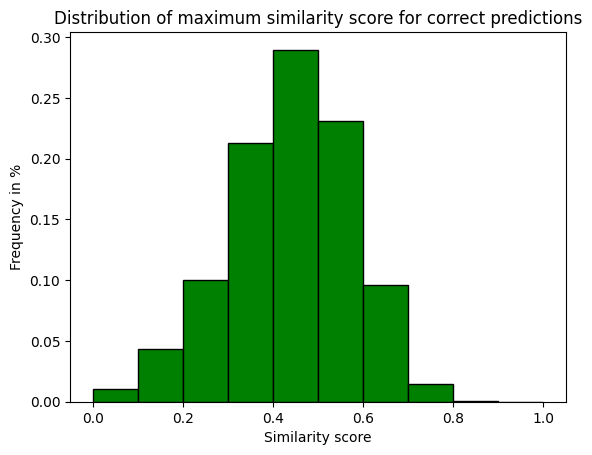

In [92]:
import matplotlib.pyplot as plt

bins = np.linspace(0,1,11)

# Example array of values
#values = correct_df['max_sim'].values
values = all_sim_scores_correct
# Plotting the distribution
plt.hist(values, bins=bins, edgecolor='black', color='green', weights=np.ones(len(values)) / len(values))

# Adding labels and title
plt.xlabel('Similarity score')
plt.ylabel('Frequency in %')
plt.title('Distribution of maximum similarity score for correct predictions')

# Display the plot
plt.show()

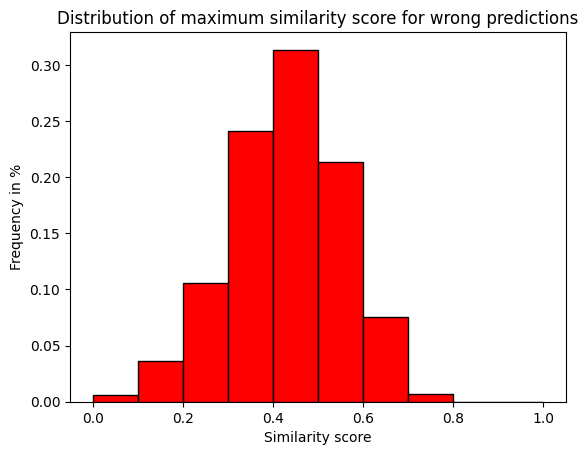

In [89]:
#values = false_df['max_sim'].values
values = all_sim_scores_false
# Plotting the distribution
plt.hist(values, bins=bins, edgecolor='black', color='red', weights=np.ones(len(values)) / len(values))

# Adding labels and title
plt.xlabel('Similarity score')
plt.ylabel('Frequency in %')
plt.title('Distribution of maximum similarity score for wrong predictions')

# Display the plot
plt.show()